In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale

plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.mlocation_scatter2 as mlocation_scatter

from mlgrad import averager_it

<frozen importlib._bootstrap>:228: RuntimeWarning: mlgrad.distance.DistanceWithScale size changed, may indicate binary incompatibility. Expected 232 from C header, got 240 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mlgrad.distance.MahalanobisDistance size changed, may indicate binary incompatibility. Expected 232 from C header, got 240 from PyObject


In [2]:
import matplotlib as mpl

In [3]:
mpl.rcParams['figure.autolayout'] = True
#mpl.rcParams

In [4]:
def permutate_values(Yp, Y, m):
    d = {}
    for yp,y in zip(Yp, Y):
        c = d.setdefault((yp,y), 0)
        d[(yp,y)] = c+1
    print(d)
    values = np.array(list(d.values()))
    keys = list(d.keys())
    indices = list(np.argsort(values))
    keys = [keys[indices[-i]] for i in range(1,m+1)]
    print(keys)
    d = dict(keys)
    for i in range(len(Y)):
        yp = Yp[i]
        Yp[i] = d[yp]

In [5]:
attr_names = ["a1","a2","a3","a4","a5","a6","a7","a8","a9","a10","a11","a12","a13"]
wine = pd.read_csv("data/wine.data", names=["class"] + attr_names)

In [6]:
wine

,class,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [7]:
Y = wine['class'].values
X = np.c_[tuple(wine[name] for name in attr_names)]
X = scale(X)
np.set_printoptions()
with np.printoptions(precision=2, linewidth=256, edgeitems=10, suppress=True):
    print(X)

[[ 1.52 -0.56  0.23 -1.17  1.91  0.81  1.03 -0.66  1.22  0.25  0.36  1.85  1.01]
 [ 0.25 -0.5  -0.83 -2.49  0.02  0.57  0.73 -0.82 -0.54 -0.29  0.41  1.11  0.97]
 [ 0.2   0.02  1.11 -0.27  0.09  0.81  1.22 -0.5   2.14  0.27  0.32  0.79  1.4 ]
 [ 1.69 -0.35  0.49 -0.81  0.93  2.49  1.47 -0.98  1.03  1.19 -0.43  1.18  2.33]
 [ 0.3   0.23  1.84  0.45  1.28  0.81  0.66  0.23  0.4  -0.32  0.36  0.45 -0.04]
 [ 1.48 -0.52  0.31 -1.29  0.86  1.56  1.37 -0.18  0.66  0.73  0.41  0.34  2.24]
 [ 1.72 -0.42  0.31 -1.47 -0.26  0.33  0.49 -0.5   0.68  0.08  0.27  1.37  1.73]
 [ 1.31 -0.17  0.89 -0.57  1.49  0.49  0.48 -0.42 -0.6  -0.    0.45  1.37  1.75]
 [ 2.26 -0.63 -0.72 -1.65 -0.19  0.81  0.95 -0.58  0.68  0.06  0.54  0.34  0.95]
 [ 1.06 -0.89 -0.35 -1.05 -0.12  1.1   1.13 -1.14  0.45  0.94  0.23  1.33  0.95]
 ...
 [ 0.72  0.22  1.18  1.5   0.37 -1.19 -1.19  0.23 -0.09  1.56 -0.95 -1.15  0.01]
 [ 0.49  2.03  1.8   1.65  0.86 -0.5  -1.07 -0.74 -0.84  1.49 -1.26 -0.98 -0.37]
 [-0.99  0.62 -0.17 -0.

In [26]:
avgmin = avragg.Minimal()
avrfunc = averager_it(func.QuantileFunc(0.98, func.Sqrt(0.001)))
avrfunc = avragg.ParameterizedAverage(func.WinsorizedSmoothFunc(func.Sqrt(0.001)), avrfunc)
hcd = mlocation_scatter.MLocationsScattersEstimator(avrfunc, avgmin, 3, 
                                    tol=1.0e-6, n_iter=100, n_iter_s=100, n_step=100)

In [27]:
hcd.fit(X)

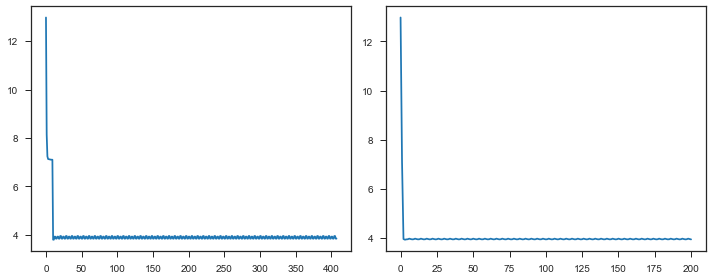

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hcd.dvals)
plt.subplot(1,2,2)
plt.plot(hcd.dvals2)
plt.show()

In [29]:
Y_p = np.array(hcd.evaluate(X))
permutate_values(Y_p, Y, 3)
print(accuracy_score(Y, Y_p))

{(2, 1): 59, (1, 2): 64, (0, 2): 3, (2, 2): 4, (0, 3): 48}
[(1, 2), (2, 1), (0, 3)]
0.9606741573033708


### Среднее арифметическое

In [30]:
arith = avragg.ArithMean()
km = mlocation_scatter.MLocationsScattersEstimator(arith, avgmin, 3, 
                                    tol=1.0e-6, n_iter=100, n_iter_s=100, n_step=100)

In [31]:
km.fit(X)

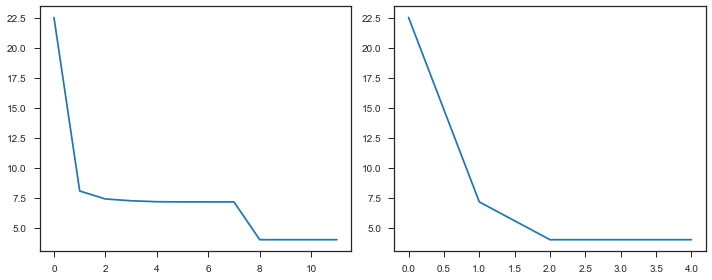

In [32]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(km.dvals)
plt.subplot(1,2,2)
plt.plot(km.dvals2)
plt.show()

In [33]:
Y2_p = np.array(km.evaluate(X))
permutate_values(Y2_p, Y, 3)
print(accuracy_score(Y, Y2_p))

{(1, 1): 59, (2, 2): 66, (0, 2): 3, (1, 2): 2, (0, 3): 48}
[(2, 2), (1, 1), (0, 3)]
0.9719101123595506


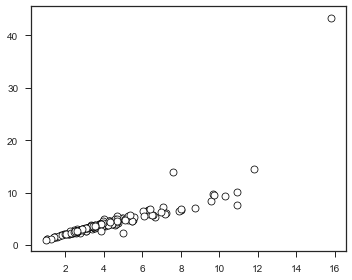

In [34]:
plt.figure(figsize=(5,4))
D = km.evaluate_dist(X)
D2 = hcd.evaluate_dist(X)
plt.scatter(D, D2, c='w', edgecolors='k', linewidth=0.75)
plt.show()

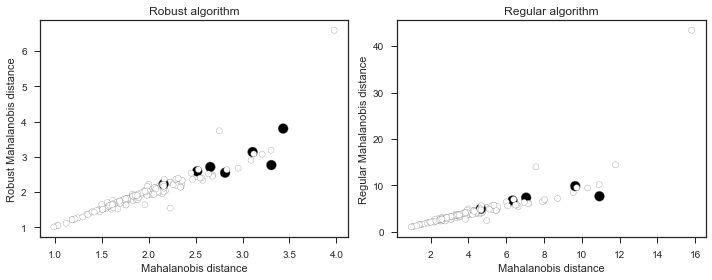

In [35]:
c1 = [('k' if x else 'w') for x in (Y_p != Y)]
c2 = [('k' if x else 'w') for x in (Y2_p != Y)]
s1 = [(100 if x else 36) for x in (Y_p != Y)]
s2 = [(100 if x else 36) for x in (Y2_p != Y)]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Robust algorithm')
plt.scatter(np.sqrt(D), np.sqrt(D2), c=c1, edgecolors='grey', s=s1)
plt.ylabel('Robust Mahalanobis distance')
plt.xlabel('Mahalanobis distance')
plt.subplot(1,2,2)
plt.title('Regular algorithm')
plt.scatter(D, D2, c=c2, edgecolors='grey', s=s2)
plt.ylabel('Regular Mahalanobis distance')
plt.xlabel('Mahalanobis distance')
plt.tight_layout()
plt.show()

In [ ]:
print(7./len(X), len(X))

In [ ]:
print(sum(Y_p != Y), sum(Y2_p != Y))